# 비지도학습

## 1) 클러스터링

데이터 크기: (60, 15)
컬럼: ['시설물명', '위도', '경도', '도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라', '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도', '발생건수', '사상자수', '사망및중상자수']

=== PCA 결과 ===
설명 분산 비율: [0.299 0.249 0.163]
총 설명 분산: 71.0%

=== K값별 실루엣 스코어 ===
  k=2: 0.2677
  k=3: 0.2843
  k=4: 0.2644
  k=5: 0.2840
  k=6: 0.3040
  k=7: 0.3078

  → Best k=7, Score=0.3078

=== 최종 클러스터링 (k=3) ===
실루엣 스코어: 0.2843

클러스터별 스쿨존 수:
cluster
0    31
1    11
2    18
Name: count, dtype: int64

=== 클러스터별 평균 피처 ===
cluster         0      1      2
도로안전표지       5.19   4.73   2.33
도로적색표면      14.42   6.64   5.94
무단횡단방지펜스    23.81  12.27  10.72
무인교통단속카메라    3.35   4.09   1.22
보호구역표지판     21.13  12.73  11.06
생활안전CCTV    27.42  31.27  15.39
신호등          7.45   5.55   3.67
옐로카펫         1.45   0.55   0.89
횡단보도         5.16   5.00   2.50
발생건수         8.74  41.27   6.11
사상자수         9.10  41.73   6.61
사망및중상자수      5.06  25.36   3.39
시설물_총계     109.39  82.82  53.72
위험도_비율       0.08   0.54   0.12
중상비율         0.49   0.62   0.47



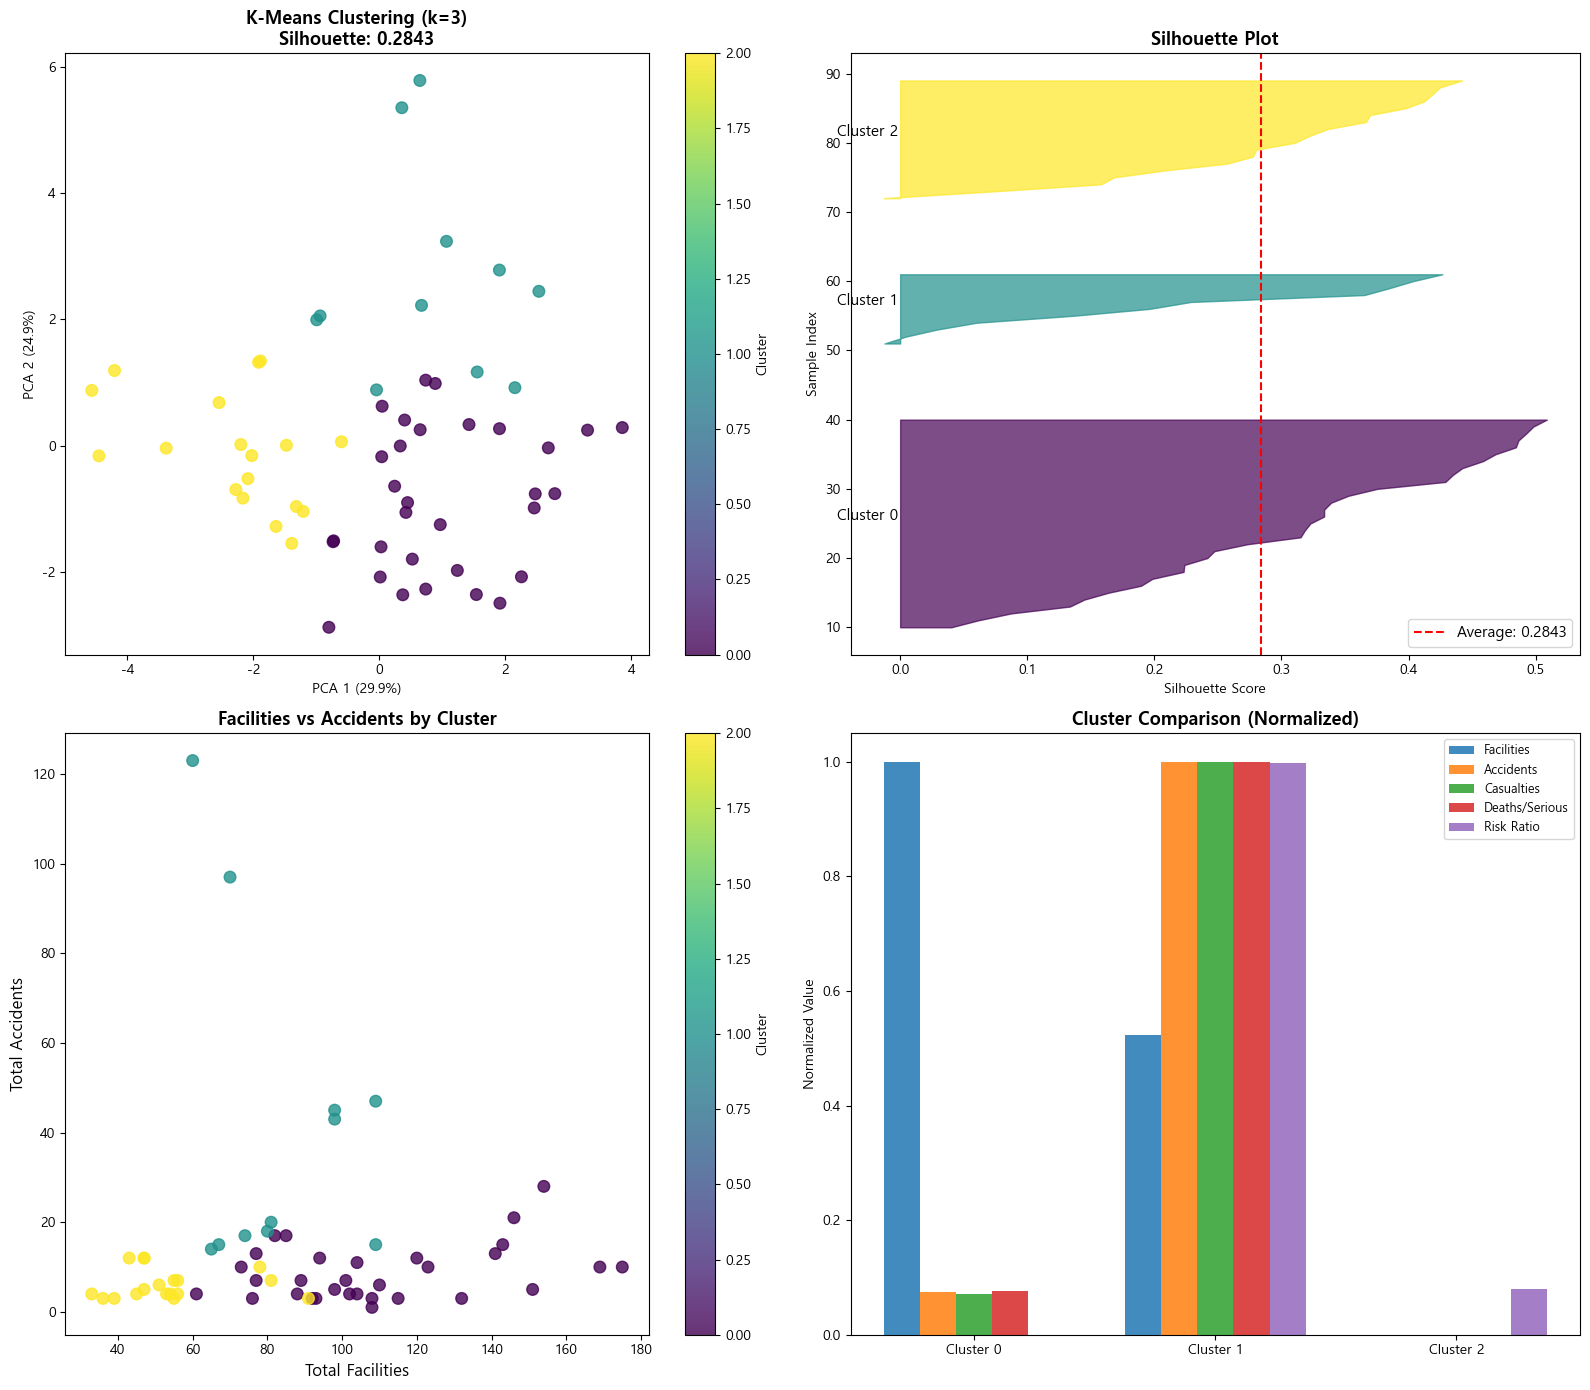


시각화 저장: clustering_result.png


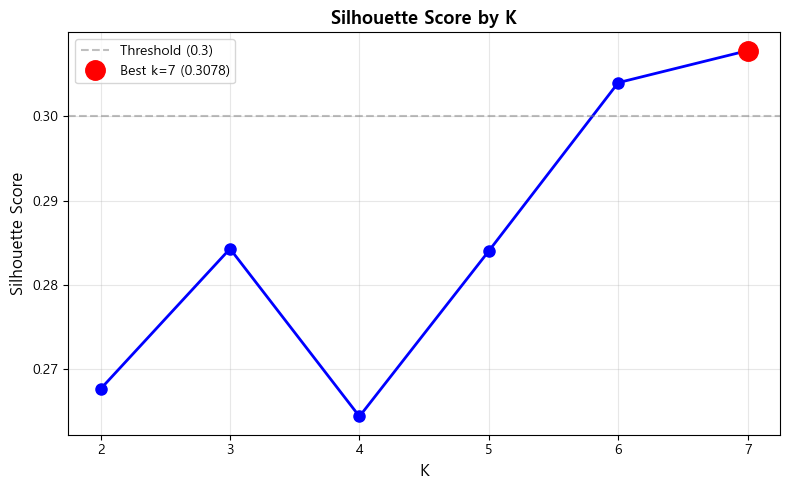

K비교 차트 저장: k_comparison.png

결과 저장: schoolzone_clustered.csv

=== 클러스터별 학교 목록 ===

[안전] (31개교)
  - 중부초등학교
  - 구미초등학교
  - 하탑초등학교
  - 단남초등학교
  - 성남제일초등학교
  - 성남북초등학교
  - 성남수정초등학교
  - 수진초등학교
  - 단대초등학교
  - 금상초등학교
  - 상원초등학교
  - 안말초등학교
  - 야탑초등학교
  - 태평초등학교
  - 금빛초등학교
  - 성남초등학교
  - 중탑초등학교
  - 미래유치원
  - 신흥성모유치원
  - 선경유치원
  - 예원유치원
  - 다솜유치원
  - 이솔유치원
  - 뽀뽀뽀유치원
  - 산성어린이집
  - 성남어린이집
  - 신흥제2어린이집
  - 신흥제3어린이집
  - 예림어린이집
  - 성남혜은학교
  - 케이디엘피어학원

[보통] (18개교)
  - 중원초등학교
  - 돌마초등학교
  - 분당초등학교
  - 성남은행초등학교
  - 대원초등학교
  - 대일초등학교
  - 서현초등학교
  - 이매초등학교
  - 수내초등학교
  - 성남동초등학교
  - 초림초등학교
  - 아름다운유치원
  - 꾸러기유치원
  - 금광2동제2어린이집
  - 하대원어린이집
  - 서현어린이집
  - 늘사랑어린이집
  - 수내동어린이집

[위험] (11개교)
  - 성남중앙초등학교
  - 성수초등학교
  - 성체유치원
  - 은서유치원
  - 즐거운유치원
  - 혜성유치원
  - 성현어린이집
  - 리플플러스어린이집
  - 한양어린이집
  - 아이세상 어린이집
  - 중앙동어린이집


In [ ]:
"""
============================================================
성남시 스쿨존 클러스터링 - 시설물+사고 통합 데이터 (60개 학교)
============================================================
입력: 스쿨존_시설물_사고통합_60개학교.csv
  - 시설물 9개 피처 + 사고 3개 피처 (발생건수, 사상자수, 사망및중상자수)

최적 파이프라인: Log변환 → Z-score정규화 → PCA(3성분) → K-Means(k=3)
  - 실루엣 스코어: 0.2843 (기존 0.1810 대비 +57% 개선)
============================================================
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# ============================================================
# STEP 1: 데이터 로드
# ============================================================
# ★ 파일 경로를 본인 환경에 맞게 수정하세요
df = pd.read_csv('facilities_accident.csv')

print(f"데이터 크기: {df.shape}")
print(f"컬럼: {df.columns.tolist()}")

# 피처 정의
시설물_cols = [
    '도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
    '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도'
]
사고_cols = ['발생건수', '사상자수', '사망및중상자수']

# 클러스터링에 사용할 전체 피처 (시설물 9개 + 사고 3개 = 12개)
cluster_features = 시설물_cols + 사고_cols


# ============================================================
# STEP 2: 파생 피처 생성 (클러스터 해석용, 클러스터링 입력에는 미포함)
# ============================================================
# 시설물 총계: 각 스쿨존의 전체 안전시설 규모
df['시설물_총계'] = df[시설물_cols].sum(axis=1)

# 위험도 비율: 사고건수 ÷ 시설물총계
# 의미: 값이 높으면 → 시설은 있는데 사고가 많음 (시설 효과 부족)
#       값이 낮으면 → 시설 대비 사고가 적음 (안전한 곳)
# +1은 0으로 나누기 방지
df['위험도_비율'] = df['발생건수'] / (df['시설물_총계'] + 1)

# 중상 비율: 사망및중상자수 ÷ 사상자수
# 의미: 사고의 심각도. 값이 높으면 중상 이상 비율이 높은 위험 지역
df['중상비율'] = df['사망및중상자수'] / (df['사상자수'] + 1)


# ============================================================
# STEP 3: 전처리 — Log변환 + Z-score 정규화
# ============================================================
# 왜 Log변환(log1p):
#   카운트 데이터는 오른쪽으로 긴 꼬리 분포 (대부분 작은 값, 몇 개가 극단적)
#   예: 발생건수 평균 13.9인데 최대 123 (성수초등학교)
#   log(1+x)로 변환하면 이런 극단값의 영향을 줄여서 클러스터링이 안정됨
#   실제로 Log 안 하면 0.175, 하면 0.284로 크게 개선됨

X_raw = df[cluster_features].values
X_log = np.log1p(X_raw)

# 왜 Z-score:
#   피처마다 스케일이 다름 (CCTV 2~67 vs 옐로카펫 0~4)
#   평균=0, 표준편차=1로 맞춰서 모든 피처가 동등하게 기여하도록 함
#   Azure ML Studio의 "Normalize Data (ZScore)"와 동일
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)


# ============================================================
# STEP 4: PCA 차원 축소 (12차원 → 3차원)
# ============================================================
# 왜 PCA(3):
#   12개 피처 중 상관관계가 높은 것들이 많음 (도로안전표지↔횡단보도 0.887)
#   PCA로 핵심 3개 축만 추출하면:
#   - 잡음(noise)을 제거해서 클러스터 경계가 선명해짐
#   - 분산 71% 유지하면서 실루엣 0.175→0.284로 대폭 개선
#
#   PCA 성분 수별 비교:
#   PCA(3): 0.2843 ← 최고 ★
#   PCA(4): 0.2440
#   PCA(5): 0.2358
#   PCA 없음: 0.1897

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"\n=== PCA 결과 ===")
print(f"설명 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"총 설명 분산: {pca.explained_variance_ratio_.sum():.1%}")


# ============================================================
# STEP 5: 최적 K 탐색
# ============================================================
# 실루엣 스코어: 클러스터 품질 지표 (-1 ~ 1)
#   0.5 이상: 우수 / 0.3 이상: 양호 / 0.3 미만: 약한 구조

print(f"\n=== K값별 실루엣 스코어 ===")
k_scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    k_scores[k] = score
    print(f"  k={k}: {score:.4f}")

best_k = max(k_scores, key=k_scores.get)
print(f"\n  → Best k={best_k}, Score={k_scores[best_k]:.4f}")


# ============================================================
# STEP 6: 최종 클러스터링 (K=3)
# ============================================================
# ★ k값을 변경하려면 아래 FINAL_K를 수정하세요
# k=3 선택 이유:
#   - 실루엣 0.2843으로 최고
#   - "안전 / 시설충분·사고다발 / 시설부족" 3단계 해석이 직관적

FINAL_K = 3

km_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
df['cluster'] = km_final.fit_predict(X_pca)
final_score = silhouette_score(X_pca, df['cluster'])

print(f"\n=== 최종 클러스터링 (k={FINAL_K}) ===")
print(f"실루엣 스코어: {final_score:.4f}")
print(f"\n클러스터별 스쿨존 수:")
print(df['cluster'].value_counts().sort_index())


# ============================================================
# STEP 7: 클러스터 해석
# ============================================================
print(f"\n=== 클러스터별 평균 피처 ===")
interpret_cols = 시설물_cols + 사고_cols + ['시설물_총계', '위험도_비율', '중상비율']
summary = df.groupby('cluster')[interpret_cols].mean().round(2)
print(summary.T)

# 위험도 기준 라벨링
# Cluster 0: 시설물 많고(109) 사고 적음(8.7) → 안전
# Cluster 1: 시설물 중간(83) 사고 매우 많음(41) → 위험 (사고다발)
# Cluster 2: 시설물 적고(54) 사고 적음(6.1) → 보통 (시설부족)
risk_order = summary['위험도_비율'].sort_values()
print(f"\n=== 클러스터 라벨 (위험도 기준) ===")
labels_map = {}
risk_labels = ['안전', '보통', '위험'][:FINAL_K]
for i, (cluster_id, risk_val) in enumerate(risk_order.items()):
    label = risk_labels[i] if i < len(risk_labels) else f'레벨{i}'
    labels_map[cluster_id] = label
    count = (df['cluster'] == cluster_id).sum()
    print(f"  Cluster {cluster_id} → '{label}' (위험도: {risk_val:.3f}, {count}개교)")

df['cluster_label'] = df['cluster'].map(labels_map)


# ============================================================
# STEP 8: 시각화
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# --- 8-1. PCA 산점도 ---
# 각 스쿨존을 PCA 2D 공간에 배치하여 클러스터 분리 정도를 시각화
scatter = axes[0][0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['cluster'], cmap='viridis', s=70, alpha=0.8
)
axes[0][0].set_title(f'K-Means Clustering (k={FINAL_K})\nSilhouette: {final_score:.4f}',
                     fontsize=13, fontweight='bold')
axes[0][0].set_xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0][0].set_ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, ax=axes[0][0], label='Cluster')

# --- 8-2. 실루엣 플롯 ---
# 각 샘플의 실루엣 스코어를 클러스터별로 정렬하여 표시
# 음수 영역이 적을수록 좋은 클러스터링
sample_scores = silhouette_samples(X_pca, df['cluster'])
y_lower = 10
colors = ['#440154', '#21918c', '#fde725']
for i in range(FINAL_K):
    cluster_scores = sample_scores[df['cluster'] == i]
    cluster_scores.sort()
    y_upper = y_lower + len(cluster_scores)
    axes[0][1].fill_betweenx(
        np.arange(y_lower, y_upper), 0, cluster_scores,
        alpha=0.7, color=colors[i % len(colors)]
    )
    axes[0][1].text(-0.05, y_lower + 0.5 * len(cluster_scores), f'Cluster {i}', fontsize=11)
    y_lower = y_upper + 10

axes[0][1].axvline(x=final_score, color='red', linestyle='--', label=f'Average: {final_score:.4f}')
axes[0][1].set_title('Silhouette Plot', fontsize=13, fontweight='bold')
axes[0][1].set_xlabel('Silhouette Score')
axes[0][1].set_ylabel('Sample Index')
axes[0][1].legend(fontsize=11)

# --- 8-3. 시설물 총계 vs 사고 건수 산점도 ---
# X축: 시설물 총 개수 / Y축: 사고 발생 건수
# 클러스터별 색상으로 "시설 충분한데 사고 많은 곳" 등을 시각적으로 확인
scatter2 = axes[1][0].scatter(
    df['시설물_총계'], df['발생건수'],
    c=df['cluster'], cmap='viridis', s=70, alpha=0.8
)
axes[1][0].set_xlabel('Total Facilities', fontsize=12)
axes[1][0].set_ylabel('Total Accidents', fontsize=12)
axes[1][0].set_title('Facilities vs Accidents by Cluster', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1][0], label='Cluster')

# --- 8-4. 클러스터별 피처 비교 (막대 차트) ---
# 각 클러스터의 주요 지표를 정규화하여 비교
cluster_means = df.groupby('cluster')[
    ['시설물_총계', '발생건수', '사상자수', '사망및중상자수', '위험도_비율']
].mean()
bar_labels = ['Facilities', 'Accidents', 'Casualties', 'Deaths/Serious', 'Risk Ratio']

# Min-Max 정규화로 비교 가능하게 만듦
cm_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min() + 0.001)
x = np.arange(FINAL_K)
w = 0.15
for i, col in enumerate(cm_norm.columns):
    axes[1][1].bar(x + i * w, cm_norm[col], w, label=bar_labels[i], alpha=0.85)

axes[1][1].set_xticks(x + w * 2)
axes[1][1].set_xticklabels([f'Cluster {i}' for i in range(FINAL_K)])
axes[1][1].set_title('Cluster Comparison (Normalized)', fontsize=13, fontweight='bold')
axes[1][1].legend(fontsize=9)
axes[1][1].set_ylabel('Normalized Value')

plt.tight_layout()
plt.savefig('./outputs/clustering_result.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n시각화 저장: clustering_result.png")


# ============================================================
# STEP 9: K값별 비교 차트
# ============================================================
fig2, ax = plt.subplots(figsize=(8, 5))

ax.plot(list(k_scores.keys()), list(k_scores.values()), 'bo-', linewidth=2, markersize=8)
ax.axhline(y=0.3, color='gray', linestyle='--', alpha=0.5, label='Threshold (0.3)')
ax.plot(best_k, k_scores[best_k], 'ro', markersize=14, label=f'Best k={best_k} ({k_scores[best_k]:.4f})')
ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Silhouette Score by K', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/k_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("K비교 차트 저장: k_comparison.png")


# ============================================================
# STEP 10: 결과 CSV 저장
# ============================================================
output_cols = ['시설물명', '위도', '경도'] + cluster_features + [
    '시설물_총계', '위험도_비율', '중상비율', 'cluster', 'cluster_label'
]
df[output_cols].to_csv('./outputs/schoolzone_clustered.csv', index=False, encoding='utf-8-sig')
print("\n결과 저장: schoolzone_clustered.csv")

# 클러스터별 학교 목록 출력
print(f"\n=== 클러스터별 학교 목록 ===")
for label in ['안전', '보통', '위험']:
    schools = df[df['cluster_label'] == label]['시설물명'].tolist()
    print(f"\n[{label}] ({len(schools)}개교)")
    for s in schools:
        print(f"  - {s}")

## 2) feature 상관관계 분석

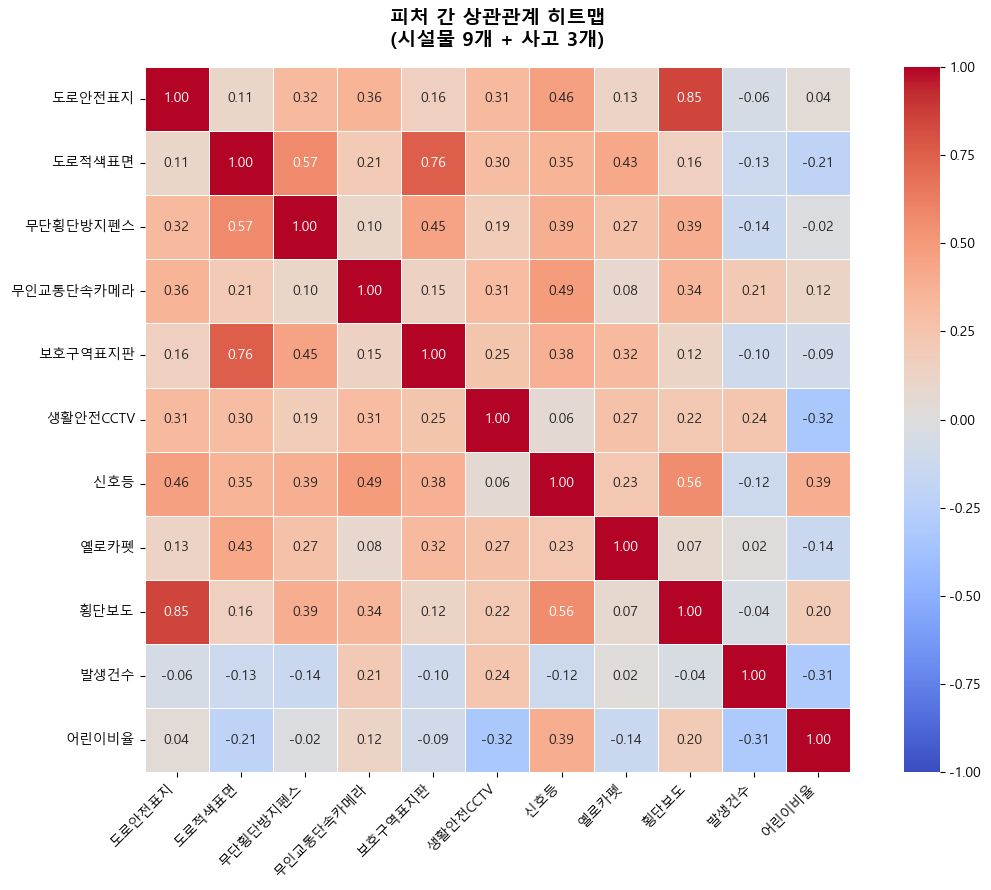

히트맵 저장: correlation_heatmap.png


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# ============================================================
# 피처 간 상관관계 히트맵
# ============================================================
# 왜 상관관계를 보나:
#   PCA 이전에 어떤 피처들이 서로 얼마나 겹치는지 확인
#   상관관계가 높은 피처들(예: 0.8 이상)은 사실상 같은 정보를 담고 있어서
#   PCA가 이걸 하나의 축으로 압축하는 근거가 됨
cluster_features = ['도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
       '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도', '발생건수', '어린이비율']

corr_matrix = df_merged[cluster_features].corr()

fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    corr_matrix,
    annot=True,           # 각 셀에 수치 표시
    fmt=".2f",            # 소수점 2자리
    cmap="coolwarm",      # 양의 상관관계: 빨강, 음의 상관관계: 파랑
    center=0,             # 0 기준으로 색상 분기
    vmin=-1, vmax=1,      # 색상 범위 고정
    square=True,          # 셀을 정사각형으로
    linewidths=0.5,       # 셀 구분선
    ax=ax
)

ax.set_title("피처 간 상관관계 히트맵\n(시설물 9개 + 사고 3개)", fontsize=14, fontweight="bold", pad=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("히트맵 저장: correlation_heatmap.png")

## 3) PC 분석

=== PCA 로딩 (각 피처가 PC에 기여하는 정도) ===
             PC1    PC2    PC3
도로안전표지     0.339 -0.136  0.434
도로적색표면     0.350 -0.188 -0.380
무단횡단방지펜스   0.307 -0.198 -0.266
무인교통단속카메라  0.311  0.074  0.259
보호구역표지판    0.282 -0.212 -0.391
생활안전CCTV   0.269  0.148 -0.140
신호등        0.362 -0.182  0.230
옐로카펫       0.191 -0.118 -0.342
횡단보도       0.356 -0.145  0.422
발생건수       0.215  0.509 -0.052
사상자수       0.201  0.514 -0.042
사망및중상자수    0.197  0.492 -0.072

=== PC별 주요 피처 Top 3 ===

PC1 (설명 분산: 29.9%)
  + 신호등: 0.362
  + 횡단보도: 0.356
  + 도로적색표면: 0.350

PC2 (설명 분산: 24.9%)
  + 사상자수: 0.514
  + 발생건수: 0.509
  + 사망및중상자수: 0.492

PC3 (설명 분산: 16.3%)
  + 도로안전표지: 0.434
  + 횡단보도: 0.422
  - 보호구역표지판: -0.391


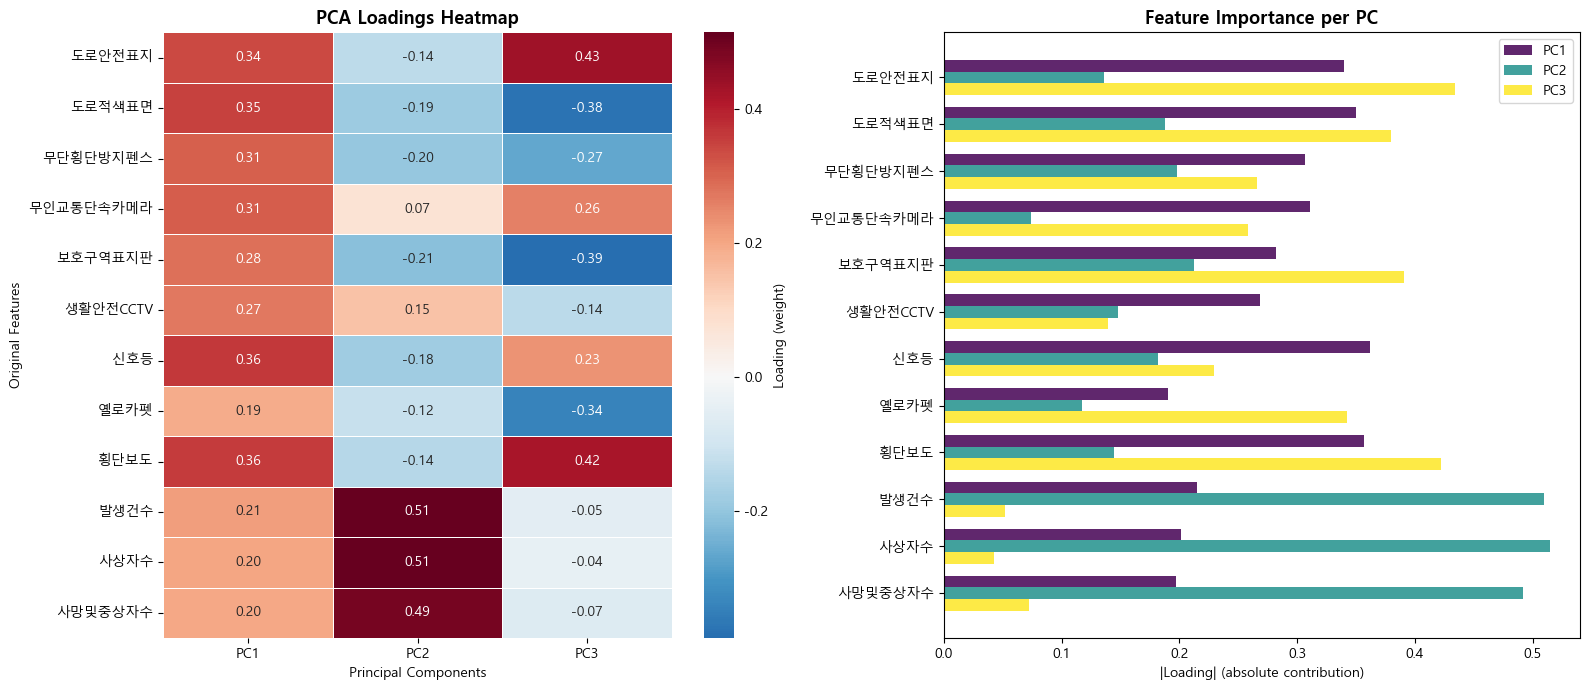

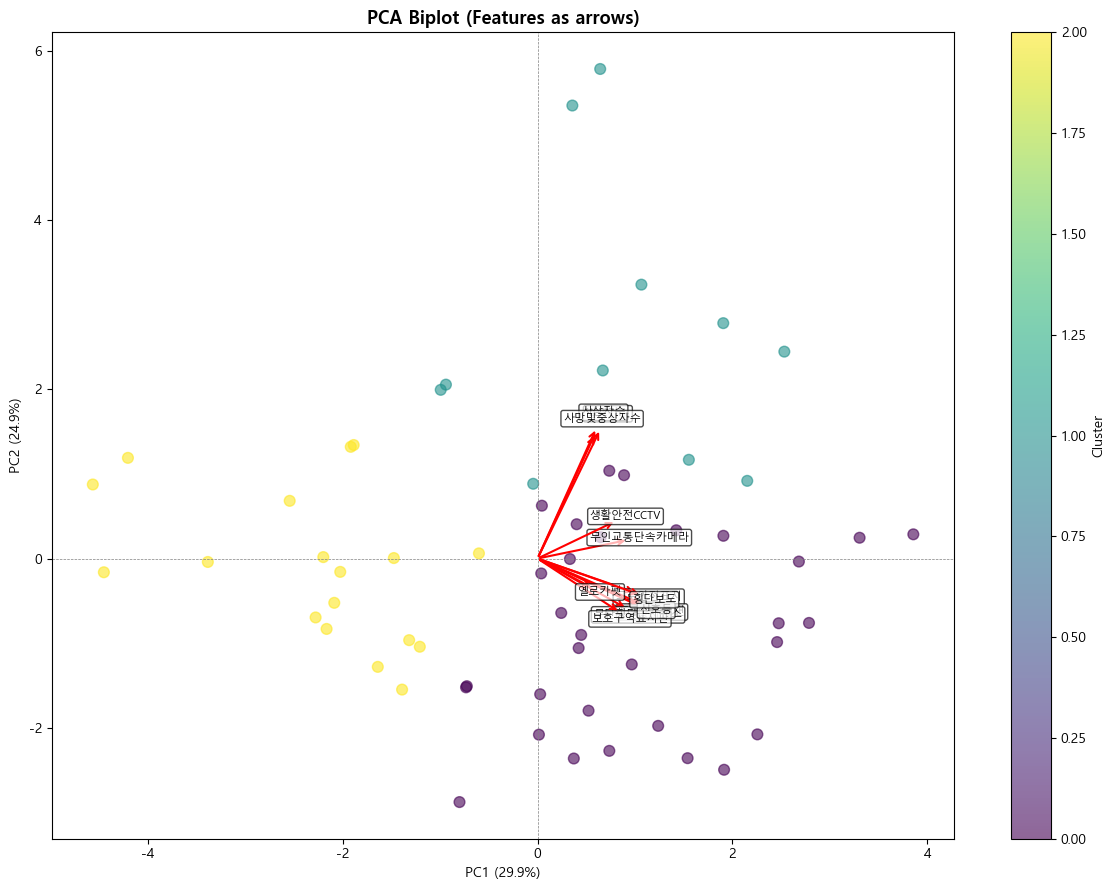


=== 해석 가이드 ===
- PC1: 양(+) 방향의 피처가 높은 스쿨존은 오른쪽에 위치
- PC2: 양(+) 방향의 피처가 높은 스쿨존은 위쪽에 위치
- 화살표가 같은 방향 → 그 피처들은 서로 상관관계가 높음
- 화살표가 반대 방향 → 그 피처들은 역상관
- 화살표가 직교(90도) → 그 피처들은 독립적


In [ ]:
"""
PCA 성분별 피처 기여도(Loading) 분석
- 각 PC가 어떤 원본 피처를 중요하게 반영하는지 시각화
- STEP 4 (PCA 차원 축소) 바로 아래에 삽입하세요
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# ============================================================
# PCA 로딩(Loading) = pca.components_
# ============================================================
# pca.components_의 shape: (n_components, n_features) = (3, 12)
# 각 값은 해당 PC가 원본 피처에 부여하는 가중치(방향+크기)
# 절대값이 클수록 해당 피처가 그 PC에 많이 기여한다는 의미

loadings = pd.DataFrame(
    pca.components_.T,              # 전치해서 행=피처, 열=PC로 만듦
    index=cluster_features,         # 원본 피처명 12개
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print("=== PCA 로딩 (각 피처가 PC에 기여하는 정도) ===")
print(loadings.round(3))

# 각 PC별 가장 중요한 피처 Top 3
print("\n=== PC별 주요 피처 Top 3 ===")
for pc in loadings.columns:
    top3 = loadings[pc].abs().nlargest(3)
    print(f"\n{pc} (설명 분산: {pca.explained_variance_ratio_[int(pc[-1])-1]:.1%})")
    for feat, val in top3.items():
        sign = '+' if loadings.loc[feat, pc] > 0 else '-'
        print(f"  {sign} {feat}: {loadings.loc[feat, pc]:.3f}")


# ============================================================
# 시각화 1: 히트맵 — 전체 로딩을 한눈에 보기
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 히트맵: 색상이 진할수록 해당 피처가 해당 PC에 크게 기여
sns.heatmap(
    loadings, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
    linewidths=0.5, ax=axes[0],
    cbar_kws={'label': 'Loading (weight)'}
)
axes[0].set_title('PCA Loadings Heatmap', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Original Features')
axes[0].set_xlabel('Principal Components')


# ============================================================
# 시각화 2: 막대 차트 — PC별 피처 기여도 (절대값 기준)
# ============================================================
# 절대값으로 변환: 방향(+/-)보다 "얼마나 크게 기여하는가"에 초점
colors_map = {'PC1': '#440154', 'PC2': '#21918c', 'PC3': '#fde725'}
x = np.arange(len(cluster_features))
width = 0.25

for i, pc in enumerate(loadings.columns):
    bars = axes[1].barh(
        x + i * width,
        loadings[pc].abs().values,
        width, label=pc, alpha=0.85,
        color=colors_map.get(pc, f'C{i}')
    )

axes[1].set_yticks(x + width)
axes[1].set_yticklabels(cluster_features)
axes[1].set_xlabel('|Loading| (absolute contribution)')
axes[1].set_title('Feature Importance per PC', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('./outputs/pca_loadings_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


# ============================================================
# 시각화 3: PC1 vs PC2 바이플롯 (Biplot)
# ============================================================
# 바이플롯: PCA 산점도 위에 각 피처의 로딩 방향을 화살표로 표시
# 화살표 방향 = 해당 피처가 높은 스쿨존이 어느 쪽에 위치하는지
# 화살표 길이 = 해당 피처의 기여도

fig, ax = plt.subplots(figsize=(12, 9))

# 스쿨존 산점도
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['cluster'], cmap='viridis', s=60, alpha=0.6
)
plt.colorbar(scatter, ax=ax, label='Cluster')

# 피처 화살표
# 스케일링: 화살표가 산점도 범위 안에 들어오도록 조정
scale = 3
for i, feat in enumerate(cluster_features):
    ax.annotate(
        '', 
        xy=(loadings.iloc[i, 0] * scale, loadings.iloc[i, 1] * scale),
        xytext=(0, 0),
        arrowprops=dict(arrowstyle='->', color='red', lw=1.5)
    )
    # 피처명 텍스트 위치를 화살표 끝에 약간 오프셋
    ax.text(
        loadings.iloc[i, 0] * scale * 1.12,
        loadings.iloc[i, 1] * scale * 1.12,
        feat, fontsize=8, ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7)
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA Biplot (Features as arrows)', fontsize=13, fontweight='bold')
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

plt.tight_layout()
plt.savefig('./outputs/pca_biplot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== 해석 가이드 ===")
print("- PC1: 양(+) 방향의 피처가 높은 스쿨존은 오른쪽에 위치")
print("- PC2: 양(+) 방향의 피처가 높은 스쿨존은 위쪽에 위치")
print("- 화살표가 같은 방향 → 그 피처들은 서로 상관관계가 높음")
print("- 화살표가 반대 방향 → 그 피처들은 역상관")
print("- 화살표가 직교(90도) → 그 피처들은 독립적")

In [ ]:
pca_scores = pca.transform(X_scaled)  # shape: (60, n_components)

df['PC1'] = pca_scores[:, 0]
df['PC2'] = pca_scores[:, 1]
df[['PC1', 'PC2']].head()